Overall solution logic described in this article:
https://medium.com/@jaems33/this-is-start-of-my-exploration-into-learning-about-reinforcement-learning-d505a68a2d6

In [121]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools
import scipy.stats as pis
from time import time
from math import *

In [895]:
max_cars = 20
max_action = 5
    
all_actions = list(range(-5,6))
states = [(i,j) for i in range(0, max_cars+1) for j in range(0, max_cars+1)]
naive_value_function = {} 
for state in states:
    naive_value_function[state] = 0

init_policy_dict = {}
for state in states:
#     init_policy_dict[state] = list(range(-max_action,max_action+1))
    init_policy_dict[state] = [0]

In [1017]:
def calc_reward_update_state(state, action, value_function):
    """Function calculates sum of returns for state, action pair using the input value func."""
    requests_1_lam = 3
    requests_2_lam = 4
    returns_1_lam = 3
    returns_2_lam = 2
    POISSON_UPPER_BOUND=11
    max_cars=20
     
    state_after_action = (min(state[0] - action, max_cars), 
                          min(state[1] + action, max_cars))
    penalty = abs(action)*2
    
    rent_prob_2 = pis.poisson.pmf(range(POISSON_UPPER_BOUND), requests_2_lam)
    rent_prob_1 = pis.poisson.pmf(range(POISSON_UPPER_BOUND), requests_1_lam)
    
    return_prob_1 = pis.poisson.pmf(range(POISSON_UPPER_BOUND), returns_1_lam)
    return_prob_2 = pis.poisson.pmf(range(POISSON_UPPER_BOUND), returns_2_lam)

    total_prob = np.reshape([i*j*np.array(rent_prob_1)*np.reshape(rent_prob_2, (-1,1)) 
                for i in return_prob_1 for j in return_prob_2], (POISSON_UPPER_BOUND,POISSON_UPPER_BOUND,POISSON_UPPER_BOUND,POISSON_UPPER_BOUND))
    
    rent_nums = np.reshape([[min(i,state_after_action[0])+min(j,state_after_action[1])] 
                            for i in list(range(POISSON_UPPER_BOUND)) 
                            for j in list(range(POISSON_UPPER_BOUND))], 
                           (POISSON_UPPER_BOUND,-1))
    probable_next_values = np.reshape([value_function[min(state_after_action[0]-min(h, state_after_action[0])+i, max_cars), 
                                                      min(state_after_action[1]-min(k, state_after_action[1])+j, max_cars)] 
                                       for i in range(POISSON_UPPER_BOUND) for j in range(POISSON_UPPER_BOUND) 
                                       for k in range(POISSON_UPPER_BOUND) for h in range(POISSON_UPPER_BOUND)], 
                                      (POISSON_UPPER_BOUND,POISSON_UPPER_BOUND,POISSON_UPPER_BOUND,POISSON_UPPER_BOUND))

    out = np.sum(10*rent_nums.T*total_prob+0.9*total_prob*probable_next_values, axis=None) - penalty
    return np.sum(out, axis=None)

def state_evaluation_max_action_selection(value_function, state, actions):
    """The function evaluates the input state using input value_func and selects action with max return"""
    act_rew = {}
    for act in actions:
        act_rew[act] = calc_reward_update_state(state, act, value_function)
    if act_rew:
        return {'max': [max(act_rew, key=act_rew.get)], 'mean': np.mean(list(act_rew.values()))} #[k for k in act_rew if act_rew[k] == max(act_rew.values())]
    else:
        return {'max': [], 'mean': 0}

def policy_evaluation(policy_dict, value_function):
    """Function evaluates input policy"""
    new_val_func = value_function.copy()

    flag = True; counter=0
    all_difs = []
    while flag:
        for state in new_val_func:
            actions = policy_dict[state]
            old_val = new_val_func[state]

            new_state_val = state_evaluation_max_action_selection(new_val_func, state, actions)['mean']
            all_difs.append(abs(old_val-new_state_val))
            new_val_func[state] = new_state_val

        counter+=1
        if not counter%20: print(f'Policy eval step:{counter}, mean dif:{np.median(all_difs)}', )
        if np.median(all_difs) < 1:
            flag = False

    return new_val_func

def filter_possible_actions(state, actions):
    """Function filters only possibel actions for current state from the input list of actions"""
    possible_actions = []
    for act in actions:
        if act<0:
            if state[1]>=abs(act): possible_actions.append(act)
        else:
            if state[0]>=abs(act): possible_actions.append(act)
    return possible_actions

def improve_policy(policy_dict, value_function):
    """Function improves input policy by selecting greedy actions for all states with resp to value function"""
    local_val_func = value_function.copy()
    new_policy_dict = {}
    all_states = [(i,j) for i in range(0, max_cars+1) for j in range(0, max_cars+1)]
    for state in all_states:
        actions = filter_possible_actions(state, all_actions)
        best_act = state_evaluation_max_action_selection(local_val_func, state, actions)['max']
        new_policy_dict[state] = best_act
    return new_policy_dict

def draw_graphs(val_func, policy_func, iter_num):
    """Function draws value func and policy func"""
    
    fig, [ax1,ax2] = plt.subplots(ncols=2,nrows=1, figsize = (24,9))

    value_df = pd.DataFrame([[k[0], k[1],val_func[k]] 
                             for k in val_func], 
                             columns=['Cars_at_1st_loc', 'Cars_at_2nd_loc', 'val'])

    policy_df = pd.DataFrame([[k[0], k[1], policy_func[k][[abs(i) 
                               for i in policy_func[k]] == max([abs(i) 
                               for i in policy_func[k]])]] for k in val_func], 
                             columns=['Cars_at_1st_loc', 'Cars_at_2nd_loc', 'val'])
    


    
    sns.heatmap(value_df.pivot('Cars_at_1st_loc', 'Cars_at_2nd_loc', 'val'), ax=ax1)
    ax1.invert_yaxis()

    sns.heatmap(policy_df.pivot('Cars_at_1st_loc', 'Cars_at_2nd_loc', 'val'), ax=ax2) 
    ax2.invert_yaxis()
    fig.suptitle(f'Iteration {iter_num}', fontsize=28)
    plt.show()
    
def equal_percentage(dict_1, dict_2):
    """Function calculates percentage of equal values for 2 input dicts"""
    bool_list = np.array(list(dict_1.values())) == np.array(list(dict_2.values()))
    return sum(bool_list)*100/len(bool_list)

def iterate_policy(policy_dict, value_function):
    """Function performs policy iteration and ouputs optimal policy"""
    flag = True
    all_policies = [policy_dict]
    all_val_funcs = [value_function]
    counter=0
    
    while flag:
        draw_graphs(all_val_funcs[-1], all_policies[-1], counter)
        all_val_funcs.append(policy_evaluation(all_policies[-1], all_val_funcs[-1]))
        all_policies.append(improve_policy(all_policies[-1], all_val_funcs[-1]))

        if equal_percentage(all_policies[-1], all_policies[-2])>=98:
            flag = False
        counter+=1
        
    return all_policies[-1]

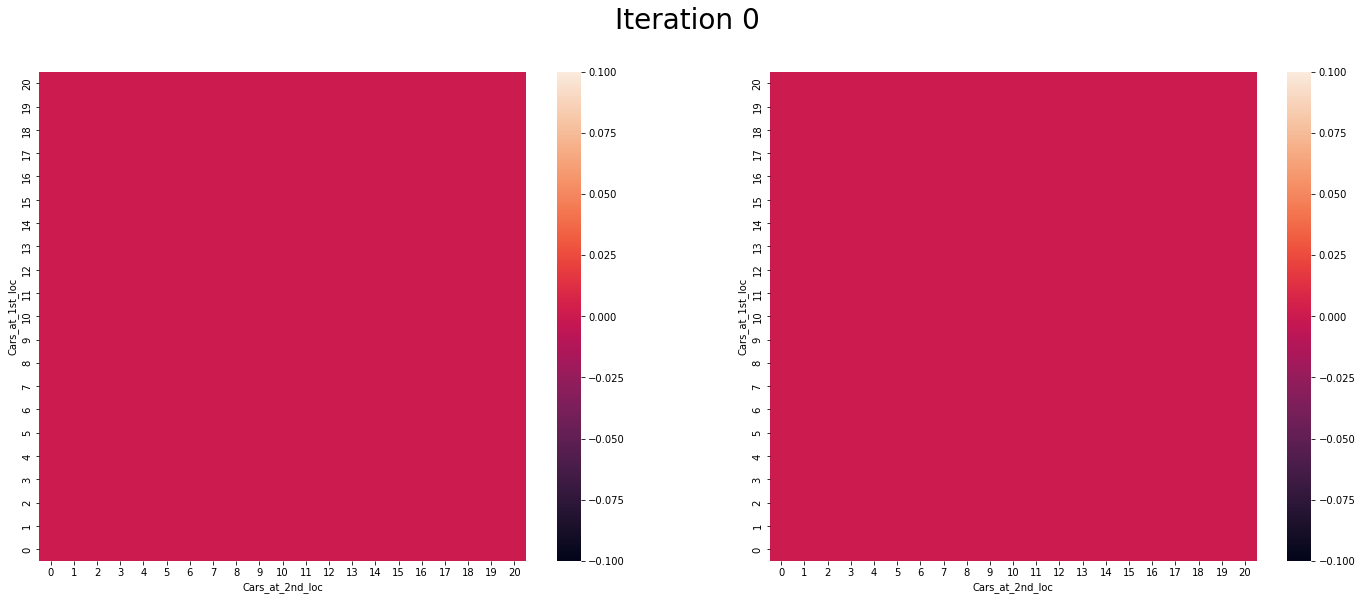

Policy eval step:20, mean dif:12.73500454831688
Policy eval step:40, mean dif:1.6873737142317111


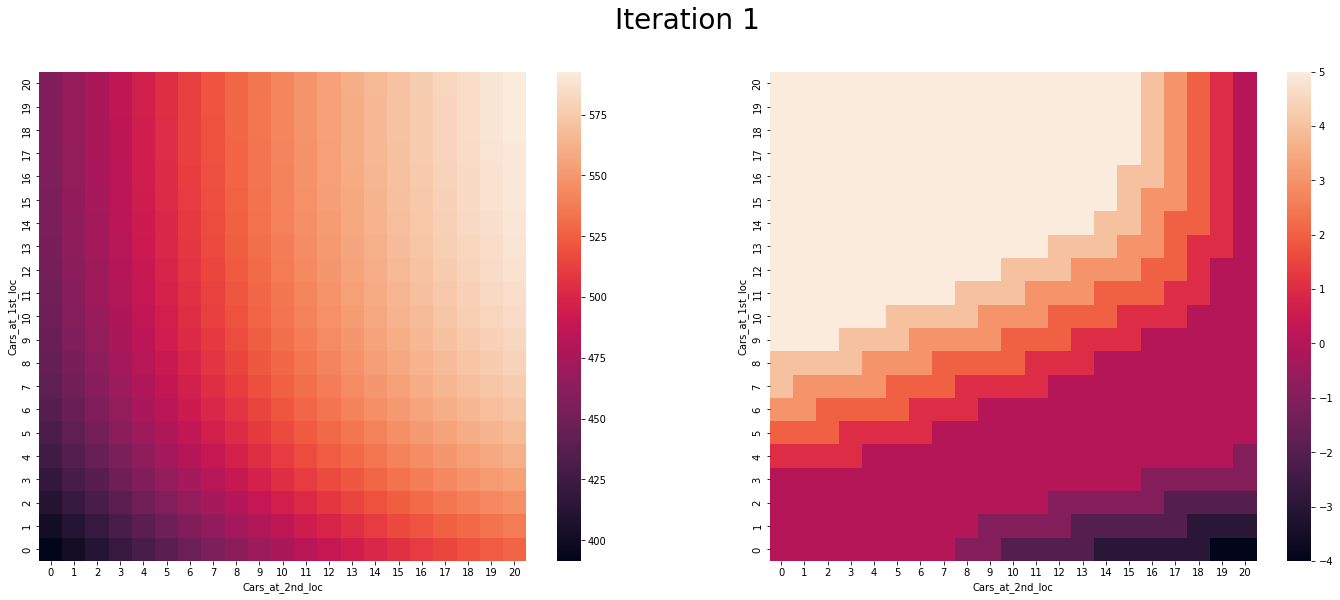

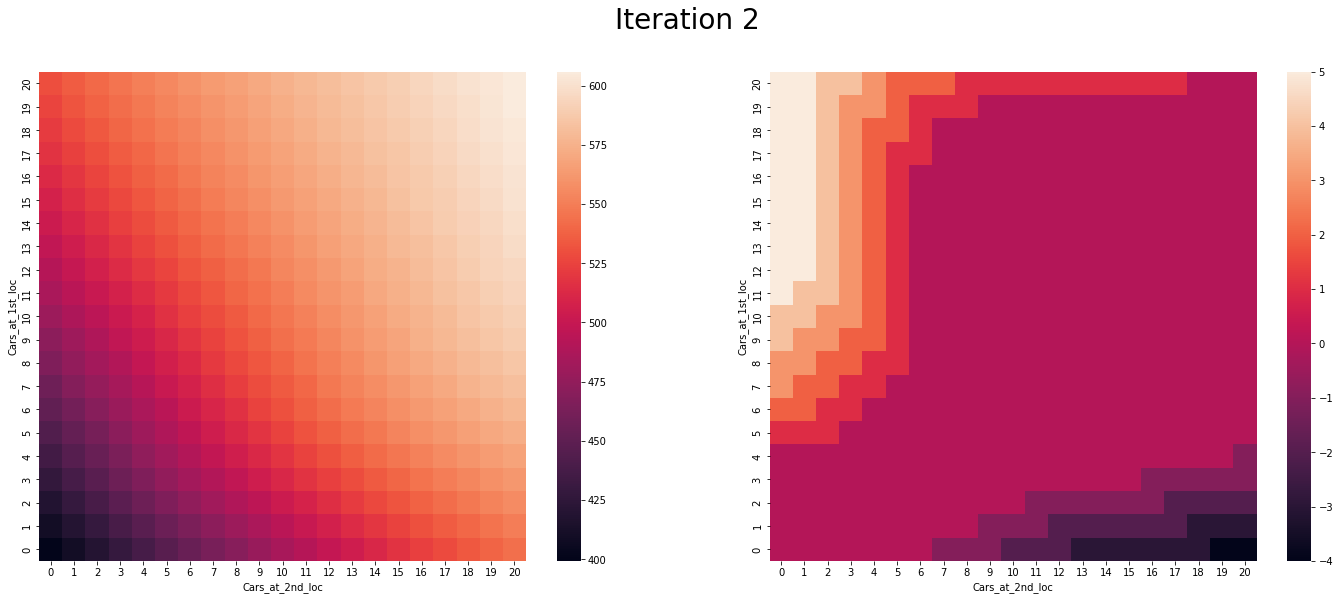

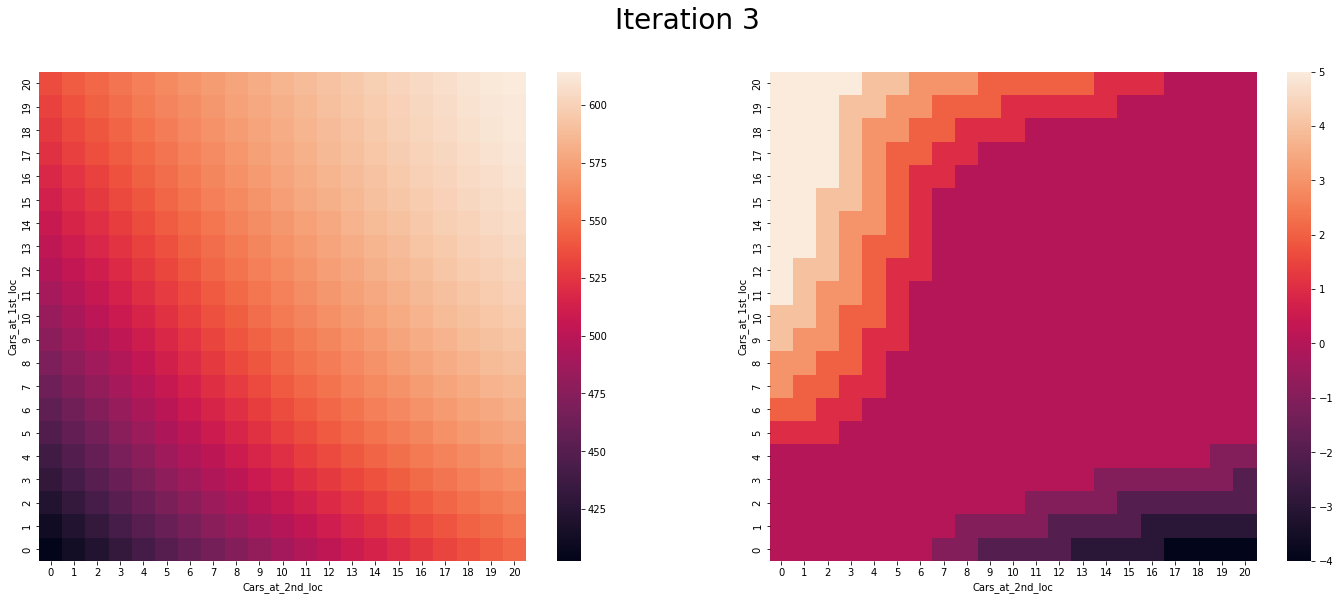

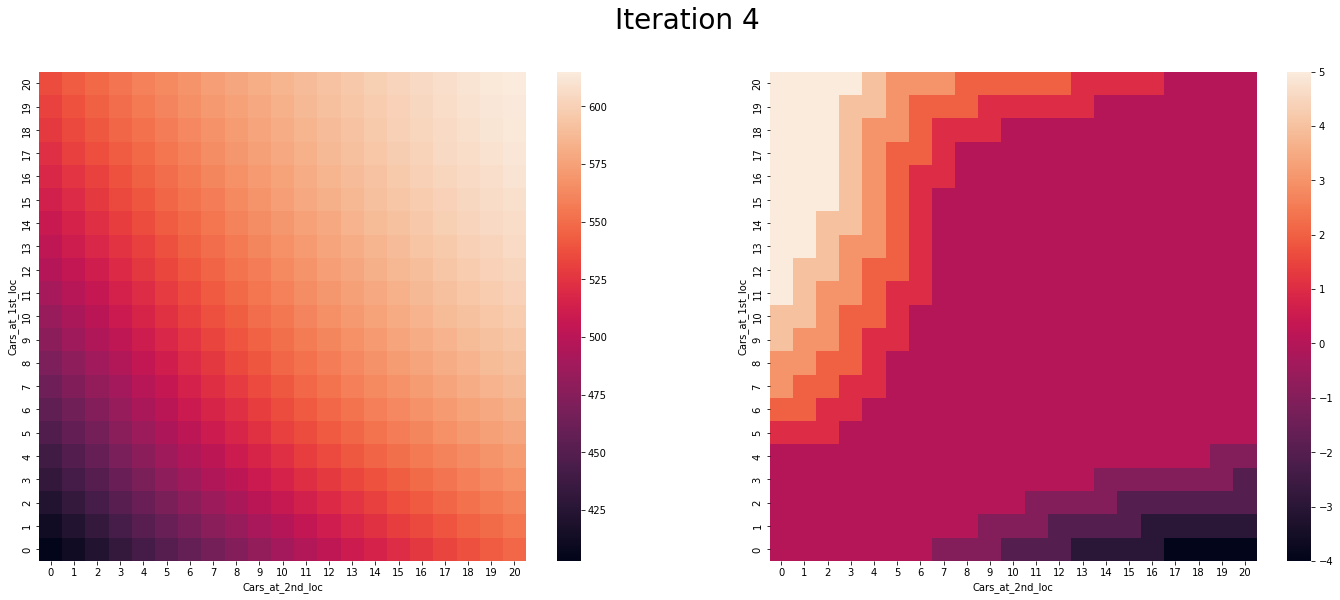

In [1018]:
final_policy = iterate_policy(init_policy_dict, naive_value_function)

# Not my code - loops

In [ ]:
https://medium.com/@jaems33/this-is-start-of-my-exploration-into-learning-about-reinforcement-learning-d505a68a2d6

In [ ]:
pBackup = dict()
def poisson(x, lam):
    global pBackup
    key = x * 10 + lam
    if key not in pBackup.keys():
        pBackup[key] = np.exp(-lam) * pow(lam, x) / factorial(x)
    return pBackup[key]

def calc_reward_update_state(state, action, stateValue):
    a = time()
    COST_OF_MOVING=2
    MAX_CARS=20
    RENTAL_CREDIT=10
    POISSON_UPPER_BOUND=11
    EXPECTED_FIRST_LOC_REQUESTS=3
    EXPECTED_SECOND_LOC_REQUESTS=4
    EXPECTED_FIRST_LOC_RETURNS=3
    EXPECTED_SECOND_LOC_RETURNS=2
    DISCOUNT_RATE = 0.9
    
    # Initiate and populate returns with cost associated with moving cars
    returns = 0.0
    returns -= COST_OF_MOVING * np.absolute(action)
    # Number of cars to start the day
    carsLoc1 = int(min(state[0] - action, MAX_CARS))
    carsLoc2 = int(min(state[1] + action, MAX_CARS))
    # Iterate over Rental Rates
    for rentalsLoc1 in range(0, POISSON_UPPER_BOUND):
        for rentalsLoc2 in range(0, POISSON_UPPER_BOUND):
            # Rental Probabilities
            rentalsProb = poisson(rentalsLoc1, EXPECTED_FIRST_LOC_REQUESTS) * poisson(rentalsLoc2, EXPECTED_SECOND_LOC_REQUESTS)
            # Total Rentals
            totalRentalsLoc1 = min(carsLoc1, rentalsLoc1)
            totalRentalsLoc2 = min(carsLoc2, rentalsLoc2)
            
            # Total Rewards
            rewards = (totalRentalsLoc1 + totalRentalsLoc2) * RENTAL_CREDIT
#             print(rentalsLoc1, rentalsLoc2, rewards)
#             rewards = (rentalsLoc1 + rentalsLoc1) * RENTAL_CREDIT
            # Iterate over Return Rates
            for returnsLoc1 in range(0, POISSON_UPPER_BOUND):
                for returnsLoc2 in range(0, POISSON_UPPER_BOUND):
                    # Return Rate Probabilities
                    prob = poisson(returnsLoc1, EXPECTED_FIRST_LOC_RETURNS) * poisson(returnsLoc2, EXPECTED_SECOND_LOC_RETURNS) * rentalsProb
                    # Number of cars at the end of the day
                    carsLoc1_prime = min(carsLoc1 - totalRentalsLoc1 + returnsLoc1, MAX_CARS) #  
                    carsLoc2_prime = min(carsLoc2 - totalRentalsLoc2 + returnsLoc2, MAX_CARS) #  
                    
                    # Number of cars at the end of the day
#                     print(rentalsLoc1, rentalsLoc2, returnsLoc1, returnsLoc2, stateValue[(carsLoc1_prime, carsLoc2_prime)])
                    returns += prob*(rewards + DISCOUNT_RATE * stateValue[(carsLoc1_prime, carsLoc2_prime)])
#                     returns += prob*DISCOUNT_RATE * stateValue[(carsLoc1_prime, carsLoc2_prime)]#(stateValue[(carsLoc1_prime, carsLoc2_prime)]) #* 
    b = time()
#     print(b-a)
    return returns#{'reward': returns, }
#             'new_state': (carsLoc1_prime, carsLoc2_prime)}

# Not my code - matrices

https://www.deep-teaching.org/notebooks/reinforcement-learning/markov-decision-processes-and-optimal-control

In [1]:
# Python Standard Library
import os

# External Modules
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import mpl_toolkits.mplot3d

from scipy.stats import poisson

REQUEST_RATE = (3., 4.)      
RETURN_RATE  = (3., 2.)

GAMMA = 0.9
RENTAL_INCOME = 10
TRANSFER_COST = 2
TRANSFER_MAX  = 5
MAX_CAPACITY  = 20

# location indicies
A = 0
B = 1

In [3]:
state_ = np.zeros([MAX_CAPACITY+1, MAX_CAPACITY+1])
state_[11, 15] = 1. # 11 cars at A and 15 cars at B
state_.shape

(21, 21)

In [4]:
state = state_.reshape(-1)
print(state.shape)
state_11_15 = state

(441,)


In [5]:
def get_most_probable_location(state):
    i = state.argmax()
    return (i//(MAX_CAPACITY+1), i%(MAX_CAPACITY+1))
def get_state_vector(a, b):
    s = np.zeros((MAX_CAPACITY+1)**2)
    s[a*(MAX_CAPACITY+1)+b] = 1
    return s

In [6]:
assert get_most_probable_location(get_state_vector(11,12)) == (11,12)
action_space = np.arange(-TRANSFER_MAX, TRANSFER_MAX+1)
print(action_space)  # cars moved  
print(np.arange(11)) # action indices# construct request transitions for one location:
# e.g. state_1 = ((0,*), (1,*), ... (20,*)) 
#     are only the probabilities for location 1

MAX_PMF = 30

def get_request_transitions_for_one_location(loc):
    """
    Construct transition matrix P_{to, from} for one location only for requests.
    The matrix has form (21, 21). 
    
    Parameters
    ----------
    loc : int
        Location: 0 or 1
    
    Returns
    -------
    numpy.ndarray
        request transition matrix

    """
    assert(loc==A or loc==B)
    # transition matrix P_{to, from} for one location only requests
    transition_matrix = np.zeros([MAX_CAPACITY+1, MAX_CAPACITY+1])
    
    request_pmf = poisson.pmf(np.arange(MAX_PMF), REQUEST_RATE[loc])
    np.testing.assert_almost_equal(request_pmf[-1], 0., decimal=12)
    for i in range(MAX_CAPACITY+1):  
        for j in range(MAX_CAPACITY+1):  
            if j==0:
                transition_matrix[i,j] = request_pmf[i:].sum()
            elif j<=i:    
                transition_matrix[i,j] = request_pmf[i-j]             
    return transition_matrix.T

[-5 -4 -3 -2 -1  0  1  2  3  4  5]
[ 0  1  2  3  4  5  6  7  8  9 10]


In [8]:
P_request_A_one_loc = get_request_transitions_for_one_location(A)
# all colums should sum to one
np.testing.assert_allclose(P_request_A_one_loc.sum(axis=0), 1.)
P_request_A_one_loc.shape


(21, 21)

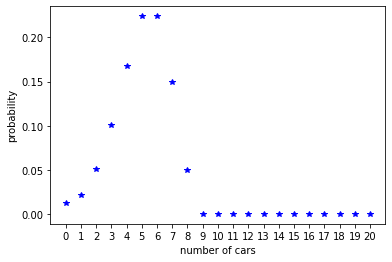

In [9]:
plt.plot(np.arange(MAX_CAPACITY+1), P_request_A_one_loc[:,8], '*b')
plt.xticks(np.arange(0, 21, step=1))
plt.xlabel("number of cars")
plt.ylabel("probability");

In [10]:
# for testing the one location transition matricies
s = np.zeros(MAX_CAPACITY+1)
s[3] = 1
a = np.dot(P_request_A_one_loc, s)
np.testing.assert_almost_equal(a.sum(), 1.)

In [11]:
def full_transition_matrix_A(transition_one_loc):
    block_size = MAX_CAPACITY+1 # for convenience
    transition_matrix = np.zeros([block_size**2, block_size**2])
    for i in range(block_size):
        transition_matrix[i:block_size**2: block_size,
                          i:block_size**2: block_size] = transition_one_loc
    return transition_matrix

def full_transition_matrix_B(transition_one_loc):
    block_size = MAX_CAPACITY+1 # for convenience
    transition_matrix = np.zeros([block_size**2, block_size**2])
    for i in range(block_size):
        transition_matrix[i*block_size:(i*block_size)+block_size,
                          i*block_size:(i*block_size)+block_size] = transition_one_loc
    return transition_matrix

In [12]:
P_request_B_one_loc = get_request_transitions_for_one_location(1)
P_request_B = full_transition_matrix_B(P_request_B_one_loc)
P_request_A = full_transition_matrix_A(P_request_A_one_loc)

P_request = np.dot(P_request_A, P_request_B)

In [13]:
MAX_PMF = 30

def get_return_transition_matrix_one_location(loc):
    """
    Construct transition matrix P_{to, from} for one location only for returns
    
    Parameters
    ----------
    loc : int
        Location: 0 or 1
    
    Returns
    -------
    numpy.ndarray
        transition matrix

    """
    assert(loc==0 or loc==1)
    transition_matrix = np.zeros([MAX_CAPACITY+1, MAX_CAPACITY+1])

    return_pmf = poisson.pmf(np.arange(MAX_PMF), RETURN_RATE[loc])
    np.testing.assert_almost_equal(return_pmf[-1], 0., decimal=12)
    for i in range(MAX_CAPACITY+1):  
        for j in range(MAX_CAPACITY+1):  
            if j==MAX_CAPACITY:
                transition_matrix[i,j] = return_pmf[j-i:].sum()
            elif j>=i and j<MAX_CAPACITY:    
                transition_matrix[i,j] = return_pmf[j-i]     
    return transition_matrix.T

P_return_A_one_loc = get_return_transition_matrix_one_location(0)
np.testing.assert_almost_equal(P_return_A_one_loc.sum(axis=0), 1.)

In [14]:
P_return_A = full_transition_matrix_A(P_return_A_one_loc)


In [15]:
def get_moves(a, b, action):
    if action > 0: # from A to B
        return min(a, action)
    else:
        return max(-b, action)

def get_nightly_moves():
    transition_matrix = np.zeros([(MAX_CAPACITY+1)**2, (MAX_CAPACITY+1)**2, action_space.shape[0]])
    for a in range(MAX_CAPACITY+1):
        for b in range(MAX_CAPACITY+1):
            for i, action in enumerate(action_space):
                old_state_index = a*(MAX_CAPACITY+1)+b
                moves = get_moves(a, b, action)
                new_a = min(a - moves, MAX_CAPACITY)
                new_b = min(b + moves, MAX_CAPACITY)
                new_state_index = new_a *(MAX_CAPACITY+1) + new_b
                transition_matrix[new_state_index, old_state_index, i] = 1.
    return transition_matrix

In [16]:
P_move = get_nightly_moves()

s = np.zeros(MAX_CAPACITY+1)
s[17] = 1
a = np.dot(P_return_A_one_loc, s)
st = np.dot(P_return_A , get_state_vector(17, 5))
np.testing.assert_almost_equal(a,st.reshape(MAX_CAPACITY+1,-1)[:,5])

P_return_B_one_loc = get_return_transition_matrix_one_location(B)
P_return_B = full_transition_matrix_B(P_return_B_one_loc)
P_return = np.dot(P_return_B, P_return_A)
P_return_request = np.dot(P_return, P_request)


In [17]:
# this is the transpose of the state transition probability kernel
P = np.ndarray(((MAX_CAPACITY+1)**2, (MAX_CAPACITY+1)**2, action_space.shape[0]))
for i in range(action_space.shape[0]): # TODO: without a loop?
    P[:,:,i] = np.dot(P_return_request, P_move[:,:,i]) 

In [27]:
def plot3d_over_states(f, zlabel="", ):
    A = np.arange(0, MAX_CAPACITY+1)
    B = np.arange(0, MAX_CAPACITY+1)
    # B, A !!!
    B, A = np.meshgrid(B, A)
    V = f.reshape(MAX_CAPACITY+1,-1)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    #ax = fig.gca(projection='3d')
    #surf = ax.plot_surface(A, B, V, rstride=1, cstride=1, cmap=cm.coolwarm,
    #                   linewidth=0, antialiased=False)
    #fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.scatter(A, B, V, c='b', marker='.')
    ax.set_xlabel("cars at A")
    ax.set_ylabel("cars at B")
    ax.set_zlabel(zlabel)
    
    ax.set_xticks(np.arange(0,21,1))
    ax.set_yticks(np.arange(0,21,1))
    #plt.xticks(np.arange(0,1,21))
    #ax.view_init(elev=10., azim=10)
    
    plt.show()

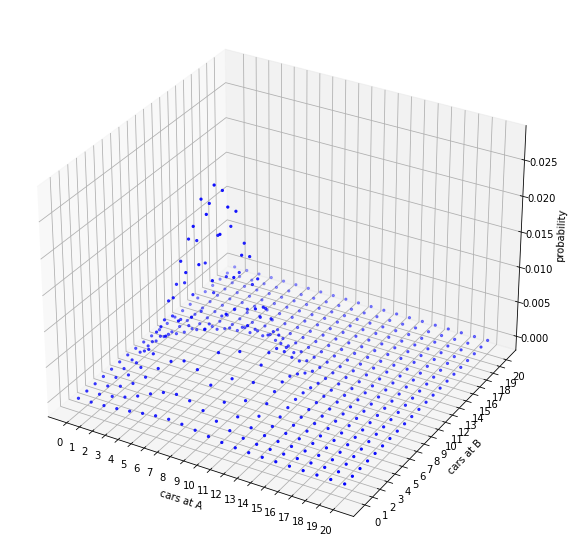

In [29]:
s_ = np.dot(P[:,:,3+TRANSFER_MAX], get_state_vector(10, 5))
plot3d_over_states(s_, 'probability')

In [22]:
def get_reward():
    
    poisson_mask = np.zeros((2, MAX_CAPACITY+1, MAX_CAPACITY+1))
    po = (poisson.pmf(np.arange(MAX_CAPACITY+1), REQUEST_RATE[A]),
          poisson.pmf(np.arange(MAX_CAPACITY+1), REQUEST_RATE[B]))
    for loc in (A,B):
        for i in range(MAX_CAPACITY+1):
            poisson_mask[loc, i, :i] = po[loc][:i]
            poisson_mask[loc, i, i] = po[loc][i:].sum()
    # the poisson mask contains the probability distribution for renting x cars (x column) 
    # in each row j, with j the number of cars available at the location

    reward = np.zeros([MAX_CAPACITY+1, MAX_CAPACITY+1, 2*TRANSFER_MAX+1])
    for a in range(MAX_CAPACITY+1):
        for b in range(MAX_CAPACITY+1):
            for action in range(-TRANSFER_MAX, TRANSFER_MAX+1):
                moved_cars = min(action, a) if action>=0 else max(action, -b)
                a_ = a - moved_cars
                a_ = min(MAX_CAPACITY, max(0, a_))
                b_ = b + moved_cars
                b_ = min(MAX_CAPACITY, max(0, b_))
                reward_a = np.dot(poisson_mask[A, a_], np.arange(MAX_CAPACITY+1)) 
                reward_b = np.dot(poisson_mask[B, b_], np.arange(MAX_CAPACITY+1))     
                reward[a, b, action+TRANSFER_MAX] = ( 
                            (reward_a + reward_b) * RENTAL_INCOME -
                            np.abs(action) * TRANSFER_COST )
                #if a==20 and b==20 and action==0:
                #    print (a_,b_, action)
                #    print (reward_a, reward_b)
                #    print (reward[a, b, action+TRANSFER_MAX])
        
    return reward

Reward = get_reward()
Reward = Reward.reshape(441,11)


def get_transition_kernel_for_policy(policy):
    # use advanced indexing to get the entiers 
    return P[:, range((MAX_CAPACITY+1)**2), policy+TRANSFER_MAX]

def get_P_reward_for_policy(policy):
    P_pi = get_transition_kernel_for_policy(policy)
    return P_pi, Reward[range((MAX_CAPACITY+1)**2), policy+TRANSFER_MAX]

def evaluate_policy(policy):
    P_pi_transpose, reward = get_P_reward_for_policy(policy)
    
    ### Here we must use P_pi_transpose.T - transformation back in time to the previous state!
    values = np.dot(np.linalg.inv(np.eye((MAX_CAPACITY+1)**2) - GAMMA * P_pi_transpose.T), reward)
    return values

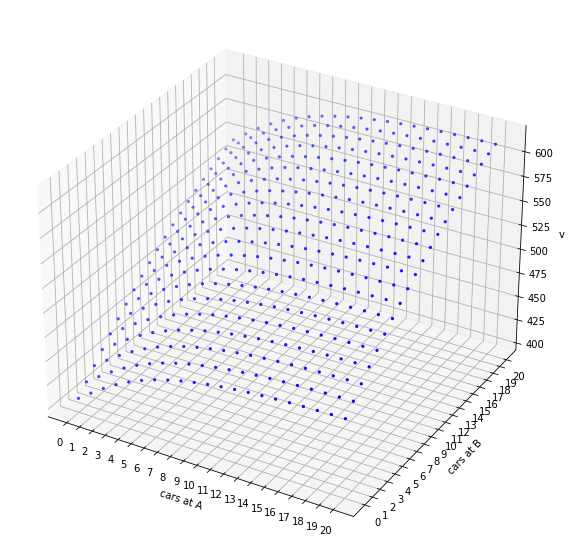

In [30]:
policy = np.ones((MAX_CAPACITY+1)**2, dtype=int) * 5
P_pi, reward = get_P_reward_for_policy(policy)

policy_ = np.zeros(((MAX_CAPACITY+1)**2), dtype=int)
values = evaluate_policy(policy_)
plot3d_over_states(values, 'v')

In [24]:
def evaluate_policy_by_iteration(policy, values = np.zeros((MAX_CAPACITY+1)**2)):
    P_pi, reward = get_P_reward_for_policy(policy)
    converged = False
    while not converged:
        new_values = reward + GAMMA * np.dot (P_pi.T, values)
        if np.allclose(new_values, values, rtol=1e-07, atol=1e-10):
            converged = True
        values = new_values
    return values

In [34]:
values_ = evaluate_policy_by_iteration(policy_)
np.testing.assert_almost_equal(values, values_, decimal=3)


In [35]:
values_

array([407.17860397, 417.15267438, 427.0179767 , 436.64951628,
       445.93293203, 454.80368439, 463.24781793, 471.28019867,
       478.92402403, 486.20104973, 493.12982181, 499.72667096,
       506.00655287, 511.98304909, 517.66758097, 523.06763159,
       528.18313454, 532.99965802, 537.47776616, 541.542329  ,
       545.08397448, 416.99843209, 426.97250251, 436.83780483,
       446.46934441, 455.75276015, 464.62351252, 473.06764606,
       481.1000268 , 488.74385216, 496.02087785, 502.94964993,
       509.54649909, 515.826381  , 521.80287722, 527.4874091 ,
       532.88745971, 538.00296267, 542.81948614, 547.29759429,
       551.36215713, 554.90380261, 426.23252551, 436.20659592,
       446.07189824, 455.70343782, 464.98685357, 473.85760594,
       482.30173947, 490.33412021, 497.97794557, 505.25497127,
       512.18374335, 518.7805925 , 525.06047441, 531.03697064,
       536.72150251, 542.12155313, 547.23705608, 552.05357956,
       556.5316877 , 560.59625054, 564.13789602, 434.47